In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [3]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from deep_visual_odometry.kitti_utils import KITTIdata
from matplotlib import pyplot as plt

In [4]:
basedir = 'dataset'

In [5]:
from deep_visual_odometry.odometry_model import OdomModel

In [6]:
batch_size = 256         # Sequences per batch
num_steps = 8         # Number of sequence steps per batch
rnn_size = 64          # Size of hidden layers in rnn_cell
num_layers = 2           # Number of hidden layers
learning_rate = 0.001

In [9]:
kitti_data = KITTIdata(basedir, 
                       sequences = ['00', '01'],
                       sequence_len = num_steps,
                       val_frac = 0,
                       test_frac = 0,
                       img_size=(150,50))

completed load sequence 00 data
completed load sequence 01 data


In [10]:
kitti_data.normalize()

normalized data


In [11]:
inputs, inter_inputs, targets = kitti_data.get_series_batch_train(batch_size = 256)

In [35]:
model = OdomModel(batch_size = 256, 
                  num_steps = 8,
                  cell_type = 'GRU',
                  rnn_size = 128,
                  num_layers = 2,
                  learning_rate = 0.001)
model.train(kitti_data, max_count = 10000, save_every_n = 1000, sequences = ['00'])

ValueError: Provided a prefix or suffix of None: None and 128

In [16]:
#inputs_test, interinputs_test, targets_test = kitti_data.load_all_sequences(mode = 'train', sequences = ['01'])

In [36]:
model = OdomModel(batch_size = 256, 
                  num_steps = 8,
                  cell_type = 'GRU',
                  rnn_size = 128,
                  num_layers = 2,
                  learning_rate = 0.001,
                  sampling = True)

output size (1, 1, 128)
seq_output shape (1, 1, 128)
shape of outputs (1, 1, 3)
shape of targets (1, 1, 3)


In [31]:
inputs,inter_inputs,targets = kitti_data.get_full_sequence(sequence = '01')
inter_inputs.reshape([1,-1,5]).shape

(1, 1100, 5)

(1, 1100, 5)

In [49]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
predictions = model.test(checkpoint, inter_inputs, priming_len = 5)

INFO:tensorflow:Restoring parameters from checkpoints/i4000_l128.ckpt


ValueError: could not broadcast input array from shape (3) into shape (5)

In [21]:
predictions.shape

(1024, 8, 3)

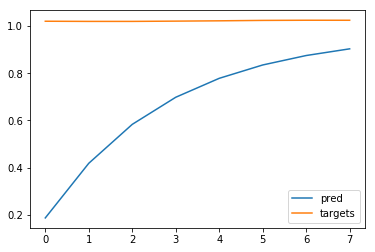

In [24]:
i = 0
j = 2
plt.plot(predictions[i,:,j],label = 'pred')
plt.plot(targets[i,:,j],label = 'targets')
plt.legend()
plt.show()